<a href="https://colab.research.google.com/github/RamenSlayer/StableDiffusionNotebooks/blob/master/in_painting_with_stable_diffusion_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-painting pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to create a custom `diffusers` pipeline for  text-guided in-painting with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).


**This example is contributed by [nagolinc](https://github.com/nagolinc)!**


In [1]:
!pip install -qq -U diffusers==0.3.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 153 kB 5.1 MB/s 
     |████████████████████████████████| 5.5 MB 49.9 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 182 kB 61.1 MB/s 
     |████████████████████████████████| 7.6 MB 42.7 MB/s 
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


You need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-5`, so you'll need to  visit [its card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [3]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from diffusers import StableDiffusionInpaintPipeline

In [4]:
device = "cuda"
model_path = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

def dummy_checker(images, **kwargs):
  return images, False

pipe.safety_checker = dummy_checker

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/284 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/636 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/822 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/609 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [7]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

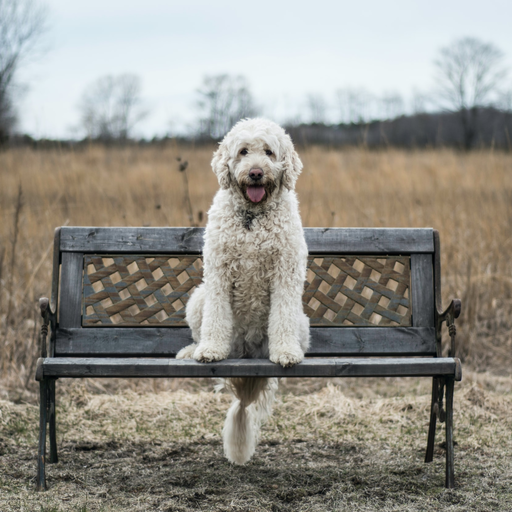

In [8]:
init_image = download_image(img_url).resize((512, 512))
init_image

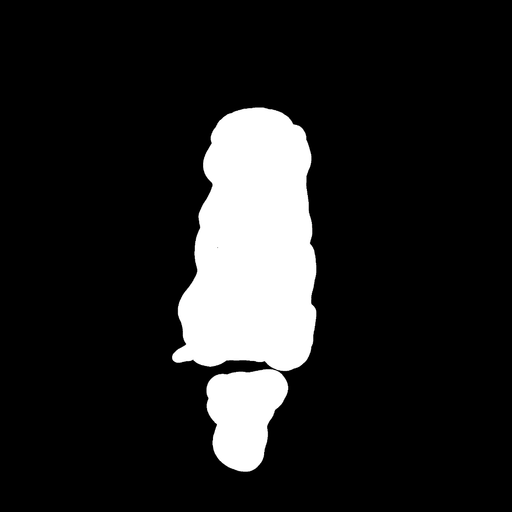

In [9]:
mask_image = download_image(mask_url).resize((512, 512))
mask_image

In [10]:
from torch import autocast
def inpaint(p, init_image, mask_image=None, strength=0.75, guidance_scale=7.5, generator=None, num_samples=1, n_iter=1):
    all_images = []
    for _ in range(n_iter):
        with autocast("cuda"):
            images = pipe(
                prompt=[p] * num_samples,
                init_image=init_image,
                mask_image=mask_image,
                strength=strength,
                guidance_scale=guidance_scale,
                generator=generator,
            ).images
        all_images.extend(images)
    return all_images

In [11]:
p = "a cat sitting on a bench"
strength=.75
guidance_scale=7.5
num_samples = 3
n_iter = 1

generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results
all_images = inpaint(p, init_image, mask_image, strength=strength, guidance_scale=guidance_scale, generator=generator, num_samples=num_samples, n_iter=n_iter)

0it [00:00, ?it/s]

In [12]:
# insert initial image in the list so we can compare side by side
all_images.insert(0, init_image)

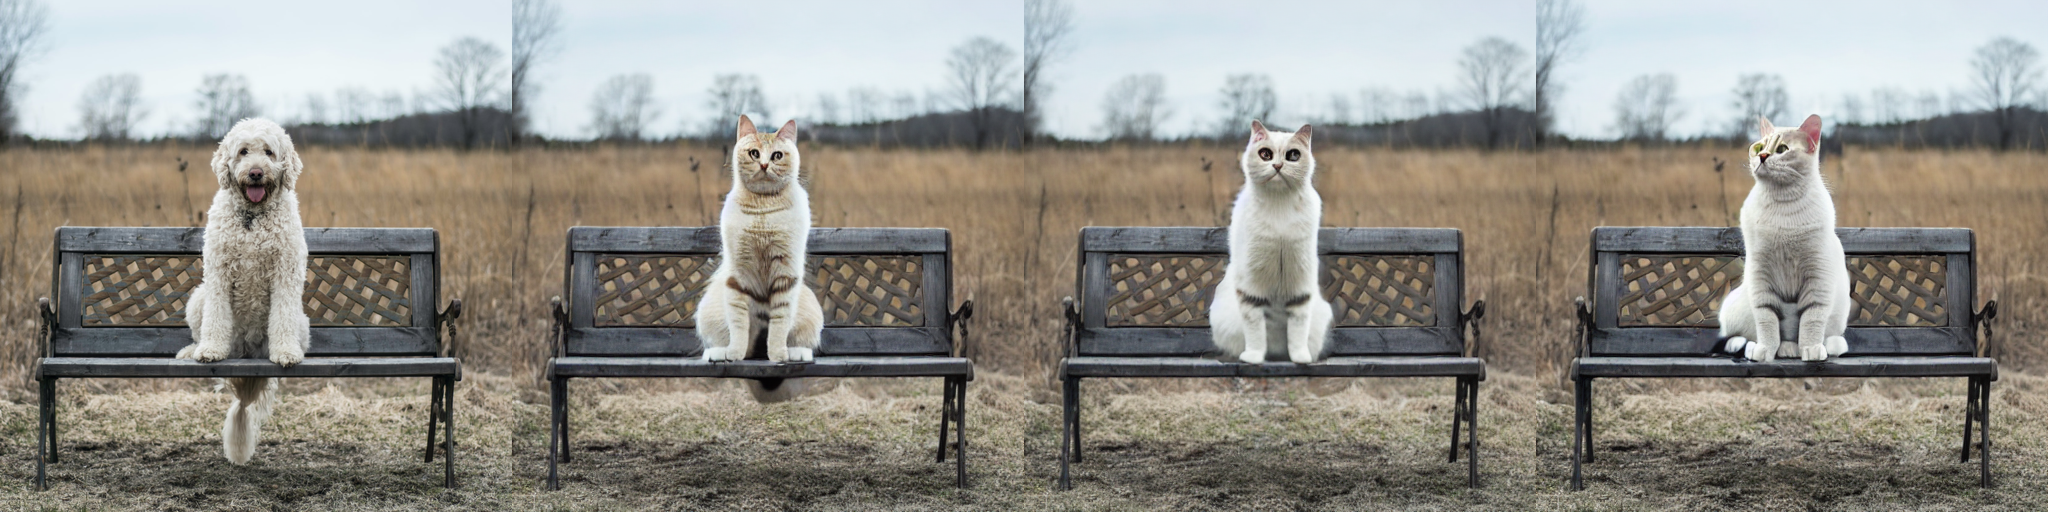

In [13]:
image_grid(all_images, n_iter, num_samples + 1)